In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4nwin_no malay.csv")

In [3]:
# Define the target variable and numeric columns
target = 'thnoth_name'
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

In [4]:
# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]

In [5]:
# Train a RandomForest model to get feature importances
X = df_0[numeric_cols_df_0]
y = df_0[target]

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [7]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

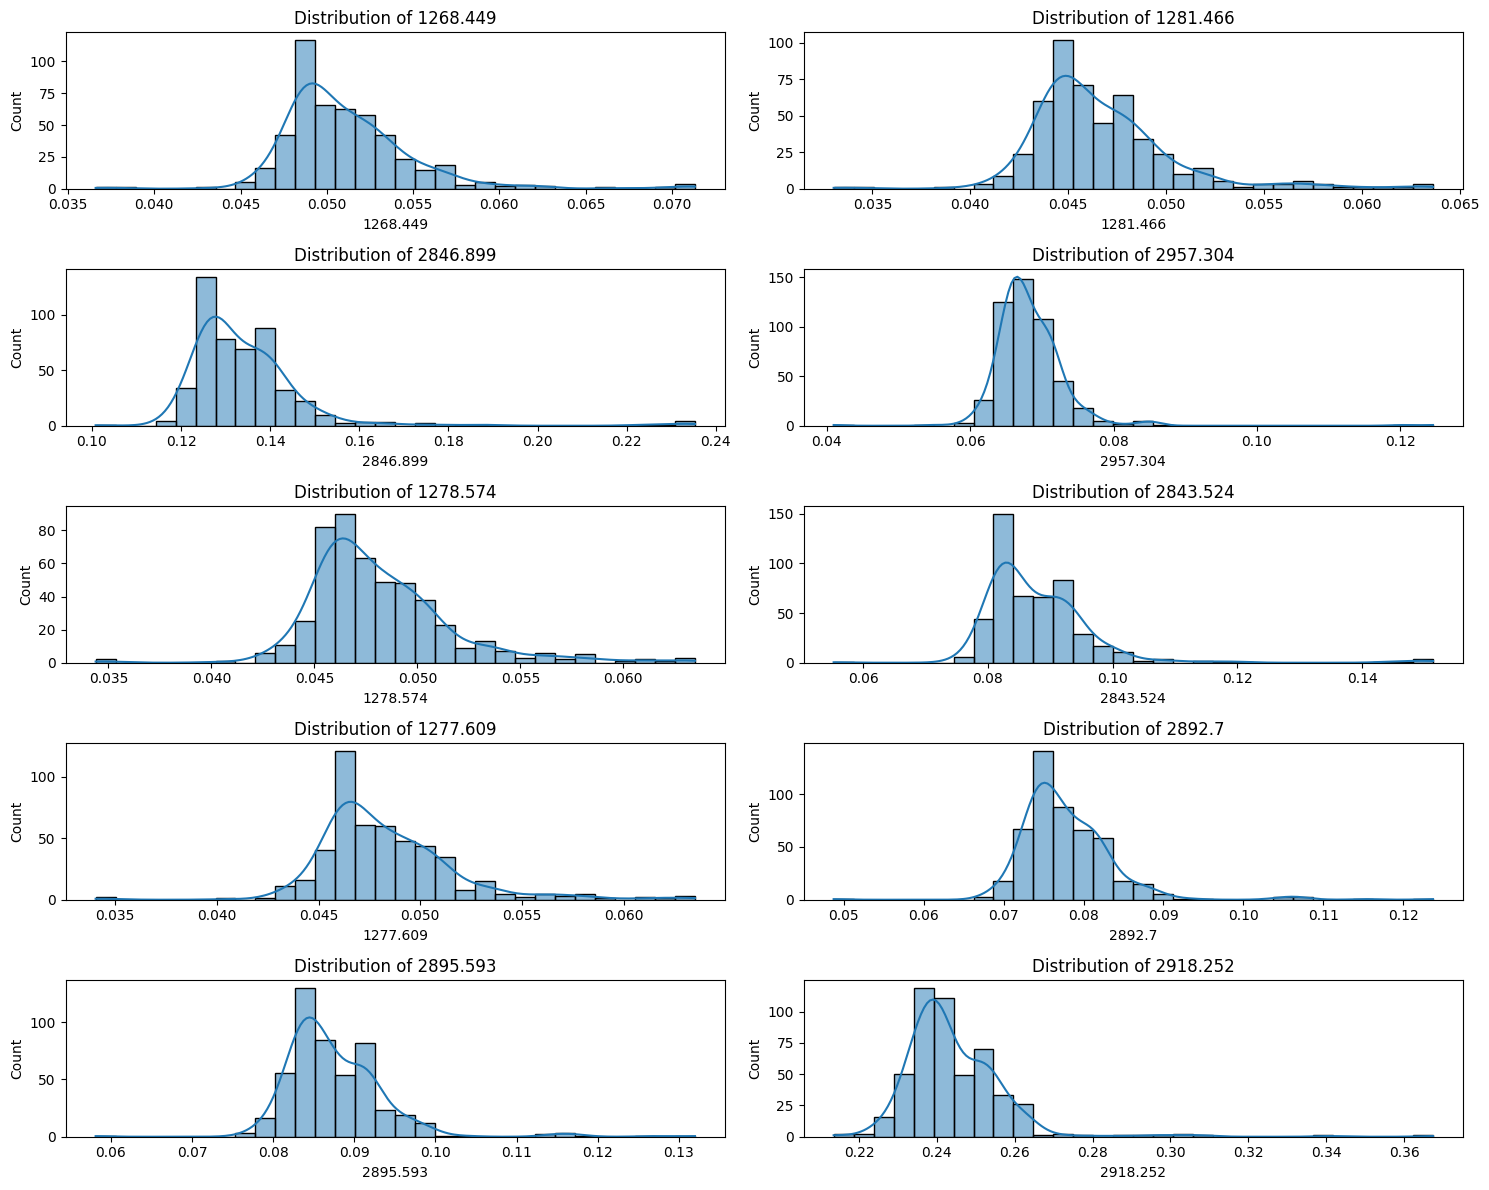

In [8]:
# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df_0[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()

In [9]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 10 important features
top_features = [numeric_cols_df_0[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)


Original Data Shape: (490, 6958)
Cleaned Data Shape: (476, 6958)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the cleaned data into train and test sets
X_cleaned = df_0_cleaned[numeric_cols_df_0]
y_cleaned = df_0_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.5, random_state=42)

# Train the RandomForest model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Analyze accuracy per 'prov_char'
df_0_test_cleaned = df_0_cleaned.loc[X_test.index]
df_0_test_cleaned['predicted'] = y_pred
df_0_test_cleaned['actual'] = y_test.values

prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())
print(prov_char_analysis)


Classification Report:
               precision    recall  f1-score   support

    Non-Thai       1.00      0.63      0.77        70
        Thai       0.87      1.00      0.93       168

    accuracy                           0.89       238
   macro avg       0.93      0.81      0.85       238
weighted avg       0.91      0.89      0.88       238

Confusion Matrix:
 [[ 44  26]
 [  0 168]]
prov_char
BBX    0.666667
CBI    1.000000
CCO    1.000000
CPN    1.000000
KBI    1.000000
KBX    0.300000
KRI    1.000000
KTX    0.708333
NRT    1.000000
NWT    1.000000
PKN    1.000000
PLG    1.000000
PNA    1.000000
PTN    1.000000
RIX    1.000000
RNG    1.000000
SNI    1.000000
SNK    1.000000
SSX    0.000000
STN    1.000000
SUX    0.583333
TRG    1.000000
dtype: float64


C:\Users\pingk\AppData\Local\Temp\ipykernel_38688\4156967957.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())


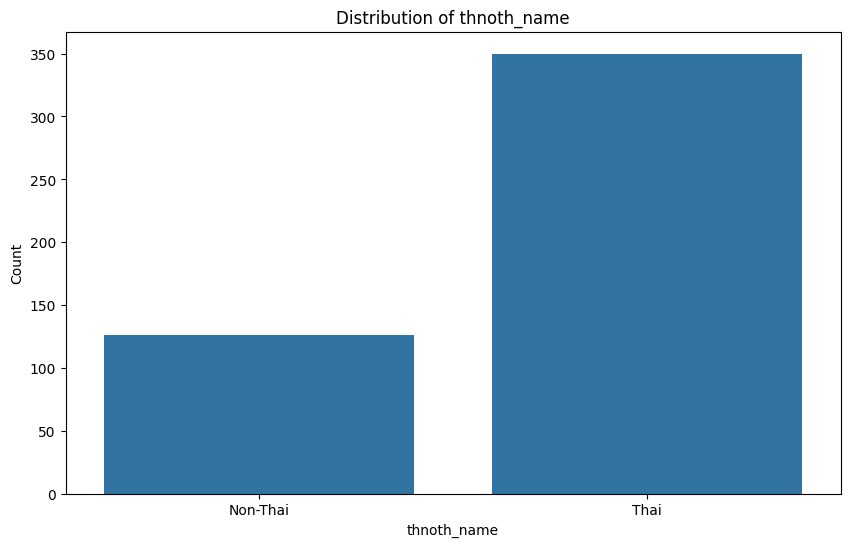

In [11]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0_cleaned, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [12]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_0_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        350
Non-Thai    126
Name: count, dtype: int64


In [13]:
# Separate Thai and Non-Thai samples
df_0_cleaned_thai = df_0_cleaned[df_0[target] == 'Thai']
df_0_cleaned_non_thai = df_0_cleaned[df_0[target] == 'Non-Thai']

C:\Users\pingk\AppData\Local\Temp\ipykernel_38688\861190095.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_0_cleaned_thai = df_0_cleaned[df_0[target] == 'Thai']
C:\Users\pingk\AppData\Local\Temp\ipykernel_38688\861190095.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_0_cleaned_non_thai = df_0_cleaned[df_0[target] == 'Non-Thai']


In [14]:
from sklearn.ensemble import IsolationForest

# Identify and remove outliers in Thai samples using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(df_0_cleaned_thai[numeric_cols_df_0])
mask = yhat != -1
df_0_cleaned_thai_cleaned = df_0_cleaned_thai[mask]

In [15]:
# Combine the cleaned Thai samples with Non-Thai samples

df_1_cleaned = pd.concat([df_0_cleaned_thai_cleaned, df_0_cleaned_non_thai], axis=0).reset_index(drop=True)

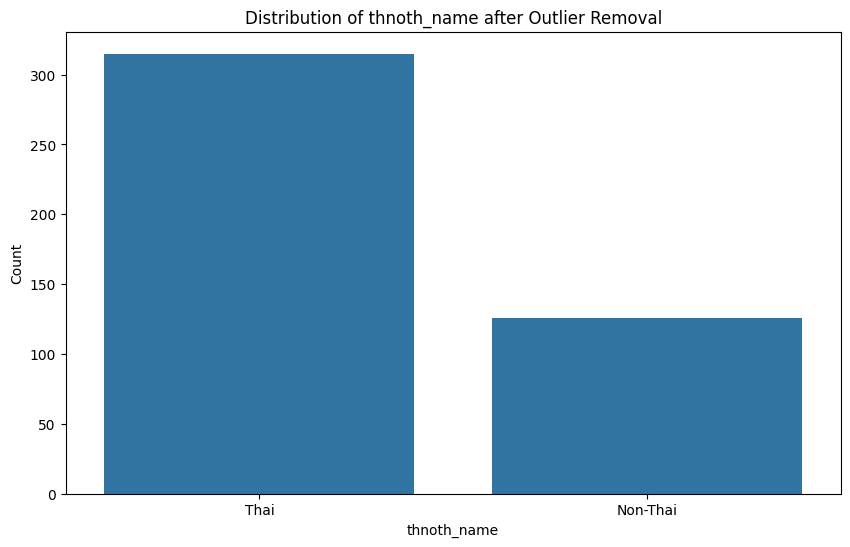

In [16]:
# Plot the distribution of thnoth_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of thnoth_name after Outlier Removal')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [17]:
# df_1_cleaned.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new_cleaned.csv", index=False)

In [18]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_1_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        315
Non-Thai    126
Name: count, dtype: int64


In [19]:
df_2 = df_1_cleaned.copy()

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encoding the 'thnoth_name' column
le = LabelEncoder()
df_2['thnoth_name_encoded'] = le.fit_transform(df_2['thnoth_name'])

In [21]:
# Define the target variable and numeric columns
numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_2 = df_2.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_2 = [col for col in numeric_cols_df_2 if col not in string_cols_df_2]

In [22]:
# Train a RandomForest model to get feature importances
X_df_2 = df_2[numeric_cols_df_2].drop(columns=['thnoth_name_encoded'])
y_df_2 = df_2['thnoth_name_encoded'].values

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# Initial model training to find consistent samples
rf = RandomForestClassifier(random_state=42)
rf.fit(X_df_2, y_df_2)

# Get predictions
df_2['predictions'] = rf.predict(X_df_2)

# Keep samples that are correctly classified
consistent_samples = df_2[df_2['thnoth_name_encoded'] == df_2['predictions']]

# Separate features and target again with consistent samples
X_df_2_consistent = consistent_samples.drop(columns=['thnoth_name', 'thnoth_name_encoded', 'predictions'])
y_df_2_consistent = consistent_samples['thnoth_name_encoded'].values

# Ensure X_df_2_consistent contains only numeric columns
X_df_2_consistent = X_df_2_consistent.select_dtypes(include=[np.number])

# Map for original string labels to numeric encoded labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 8: Apply undersampling to achieve a balanced dataset
rus = RandomUnderSampler(sampling_strategy={label_mapping['Thai']: 126, label_mapping['Non-Thai']: 126}, random_state=42)
X_df_2_balanced, y_df_2_balanced = rus.fit_resample(X_df_2_consistent, y_df_2_consistent)

# Step 9: Display the new distribution of 'thnoth_name'
balanced_df = consistent_samples.iloc[rus.sample_indices_]
thnoth_name_distribution = balanced_df['thnoth_name'].value_counts()
print(thnoth_name_distribution)


thnoth_name
Non-Thai    126
Thai        126
Name: count, dtype: int64


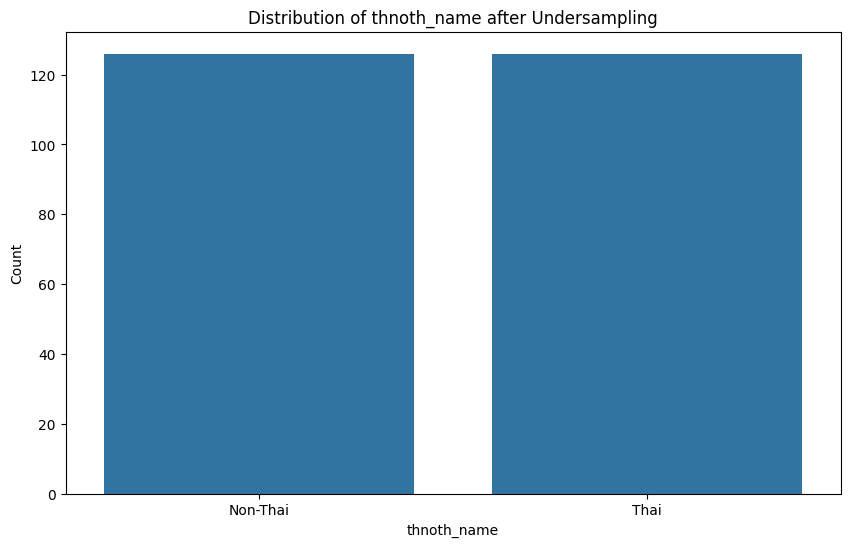

In [24]:
# Check the distribution of 'thnoth_name' after undersampling

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, x='thnoth_name')
plt.title('Distribution of thnoth_name after Undersampling')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


Mean Accuracy: 0.7383507528516048
Left out group: ['BBX'], Accuracy: 0.0
Left out group: ['CBI'], Accuracy: 1.0
Left out group: ['CCO'], Accuracy: 1.0
Left out group: ['CPN'], Accuracy: 0.9411764705882353
Left out group: ['KBI'], Accuracy: 0.9
Left out group: ['KBX'], Accuracy: 0.16666666666666666
Left out group: ['KRI'], Accuracy: 1.0
Left out group: ['KTX'], Accuracy: 0.2682926829268293
Left out group: ['NRT'], Accuracy: 1.0
Left out group: ['NWT'], Accuracy: 1.0
Left out group: ['PKN'], Accuracy: 1.0
Left out group: ['PLG'], Accuracy: 0.0
Left out group: ['PNA'], Accuracy: 1.0
Left out group: ['PTN'], Accuracy: 0.5
Left out group: ['RIX'], Accuracy: 0.5789473684210527
Left out group: ['RNG'], Accuracy: 1.0
Left out group: ['SKM'], Accuracy: 1.0
Left out group: ['SNI'], Accuracy: 0.8888888888888888
Left out group: ['SNK'], Accuracy: 0.8
Left out group: ['SSX'], Accuracy: 0.3333333333333333
Left out group: ['STN'], Accuracy: 1.0
Left out group: ['SUX'], Accuracy: 0.9047619047619048
Le

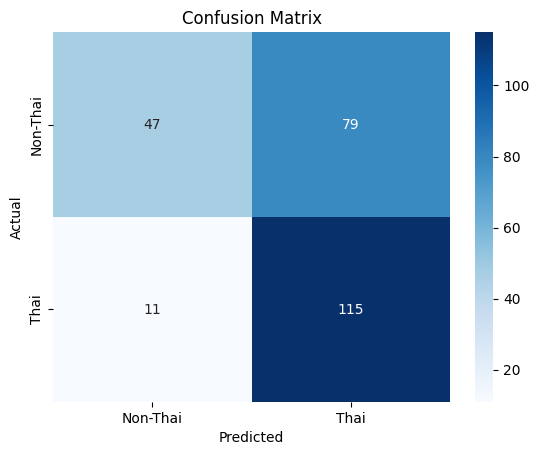

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and encode the 'prov_char' column
le_prov = LabelEncoder()
prov_char_encoded = le_prov.fit_transform(balanced_df['prov_char'])

# Define features and target for the balanced dataset
X_balanced = balanced_df.drop(columns=['thnoth_name', 'thnoth_name_encoded'])
y_balanced = balanced_df['thnoth_name_encoded'].values

# Ensure X_balanced contains only numeric columns
X_balanced = X_balanced.select_dtypes(include=[np.number])

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Arrays to store results
accuracies = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    accuracies.append(accuracy)
    left_out_groups.append(balanced_df['prov_char'].iloc[test_idx].unique())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [26]:
balanced_df.reset_index(drop=True, inplace=True)
balanced_df

,prov_char,country_char,wavenumber,649.893,650.376,650.858,651.34,651.822,652.304,652.786,...,3999.158,3999.64,4000.122,tgp_name,dgp_name,fgp_name,country_name,thnoth_name,thnoth_name_encoded,predictions
0,KTX,ID,ID-KTX-068-2306-010_002,0.009999,0.010936,0.012060,0.013193,0.014161,0.014829,0.015131,...,-0.000193,-0.000141,-0.000068,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0,0
1,KBX,ID,ID-KBX-068-2307-015_002_adah2opik,0.011787,0.012684,0.013509,0.014131,0.014446,0.014396,0.013982,...,0.000682,0.000577,0.000490,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0,0
2,SUX,ID,ID-SUX-073-2311-001_005,0.018855,0.018050,0.017008,0.015901,0.014902,0.014138,0.013663,...,0.000396,0.000478,0.000577,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0,0
3,KTX,ID,ID-KTX-068-2306-002_005,0.013460,0.013085,0.013149,0.013695,0.014654,0.015859,0.017094,...,-0.000579,-0.000557,-0.000494,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0,0
4,KTX,ID,ID-KTX-068-2308-035_004,0.011486,0.011184,0.010776,0.010319,0.009914,0.009674,0.009681,...,-0.002616,-0.002649,-0.002678,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,SNI,TH,TH-SNI-011-2312-001_008,0.021554,0.022777,0.023640,0.024057,0.024010,0.023549,0.022770,...,-0.003038,-0.003160,-0.003289,Group 2,Group 2,Group 3,Thailand,Thai,1,1
248,CPN,TH,TH-CPN-005-2311-001_002,0.019816,0.019473,0.018548,0.017158,0.015530,0.013942,0.012636,...,0.003498,0.003328,0.003198,Group 2,Group 2,Group 2,Thailand,Thai,1,1
249,CBI,TH,TH-CBI-028-2312-001_005,0.014804,0.014420,0.013718,0.012822,0.011897,0.011099,0.010544,...,-0.002224,-0.002208,-0.002186,Group 1,Group 1,Group 1,Thailand,Thai,1,1
250,SNI,TH,TH-SNI-004-2311-001_005,0.019338,0.018514,0.017306,0.015964,0.014775,0.013966,0.013643,...,0.003740,0.003836,0.003866,Group 2,Group 2,Group 3,Thailand,Thai,1,1


In [27]:
balanced_df.drop(columns=['thnoth_name_encoded', 'predictions'], inplace=True)

C:\Users\pingk\AppData\Local\Temp\ipykernel_38688\1718170853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df.drop(columns=['thnoth_name_encoded', 'predictions'], inplace=True)


In [28]:
balanced_df

,prov_char,country_char,wavenumber,649.893,650.376,650.858,651.34,651.822,652.304,652.786,...,3998.194,3998.676,3999.158,3999.64,4000.122,tgp_name,dgp_name,fgp_name,country_name,thnoth_name
0,KTX,ID,ID-KTX-068-2306-010_002,0.009999,0.010936,0.012060,0.013193,0.014161,0.014829,0.015131,...,-0.000237,-0.000224,-0.000193,-0.000141,-0.000068,Group 3,Group 2,Group 4,Indonesia,Non-Thai
1,KBX,ID,ID-KBX-068-2307-015_002_adah2opik,0.011787,0.012684,0.013509,0.014131,0.014446,0.014396,0.013982,...,0.000856,0.000782,0.000682,0.000577,0.000490,Group 3,Group 2,Group 4,Indonesia,Non-Thai
2,SUX,ID,ID-SUX-073-2311-001_005,0.018855,0.018050,0.017008,0.015901,0.014902,0.014138,0.013663,...,0.000310,0.000339,0.000396,0.000478,0.000577,Group 3,Group 2,Group 3,Indonesia,Non-Thai
3,KTX,ID,ID-KTX-068-2306-002_005,0.013460,0.013085,0.013149,0.013695,0.014654,0.015859,0.017094,...,-0.000523,-0.000566,-0.000579,-0.000557,-0.000494,Group 3,Group 2,Group 4,Indonesia,Non-Thai
4,KTX,ID,ID-KTX-068-2308-035_004,0.011486,0.011184,0.010776,0.010319,0.009914,0.009674,0.009681,...,-0.002519,-0.002572,-0.002616,-0.002649,-0.002678,Group 3,Group 2,Group 4,Indonesia,Non-Thai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,SNI,TH,TH-SNI-011-2312-001_008,0.021554,0.022777,0.023640,0.024057,0.024010,0.023549,0.022770,...,-0.002880,-0.002940,-0.003038,-0.003160,-0.003289,Group 2,Group 2,Group 3,Thailand,Thai
248,CPN,TH,TH-CPN-005-2311-001_002,0.019816,0.019473,0.018548,0.017158,0.015530,0.013942,0.012636,...,0.003868,0.003685,0.003498,0.003328,0.003198,Group 2,Group 2,Group 2,Thailand,Thai
249,CBI,TH,TH-CBI-028-2312-001_005,0.014804,0.014420,0.013718,0.012822,0.011897,0.011099,0.010544,...,-0.002203,-0.002224,-0.002224,-0.002208,-0.002186,Group 1,Group 1,Group 1,Thailand,Thai
250,SNI,TH,TH-SNI-004-2311-001_005,0.019338,0.018514,0.017306,0.015964,0.014775,0.013966,0.013643,...,0.003468,0.003606,0.003740,0.003836,0.003866,Group 2,Group 2,Group 3,Thailand,Thai


In [29]:
# balanced_df.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4nwin_nm_blncd.csv", index=False)

the BEST
don't mess it up

In [30]:
balanced_df

,prov_char,country_char,wavenumber,649.893,650.376,650.858,651.34,651.822,652.304,652.786,...,3998.194,3998.676,3999.158,3999.64,4000.122,tgp_name,dgp_name,fgp_name,country_name,thnoth_name
0,KTX,ID,ID-KTX-068-2306-010_002,0.009999,0.010936,0.012060,0.013193,0.014161,0.014829,0.015131,...,-0.000237,-0.000224,-0.000193,-0.000141,-0.000068,Group 3,Group 2,Group 4,Indonesia,Non-Thai
1,KBX,ID,ID-KBX-068-2307-015_002_adah2opik,0.011787,0.012684,0.013509,0.014131,0.014446,0.014396,0.013982,...,0.000856,0.000782,0.000682,0.000577,0.000490,Group 3,Group 2,Group 4,Indonesia,Non-Thai
2,SUX,ID,ID-SUX-073-2311-001_005,0.018855,0.018050,0.017008,0.015901,0.014902,0.014138,0.013663,...,0.000310,0.000339,0.000396,0.000478,0.000577,Group 3,Group 2,Group 3,Indonesia,Non-Thai
3,KTX,ID,ID-KTX-068-2306-002_005,0.013460,0.013085,0.013149,0.013695,0.014654,0.015859,0.017094,...,-0.000523,-0.000566,-0.000579,-0.000557,-0.000494,Group 3,Group 2,Group 4,Indonesia,Non-Thai
4,KTX,ID,ID-KTX-068-2308-035_004,0.011486,0.011184,0.010776,0.010319,0.009914,0.009674,0.009681,...,-0.002519,-0.002572,-0.002616,-0.002649,-0.002678,Group 3,Group 2,Group 4,Indonesia,Non-Thai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,SNI,TH,TH-SNI-011-2312-001_008,0.021554,0.022777,0.023640,0.024057,0.024010,0.023549,0.022770,...,-0.002880,-0.002940,-0.003038,-0.003160,-0.003289,Group 2,Group 2,Group 3,Thailand,Thai
248,CPN,TH,TH-CPN-005-2311-001_002,0.019816,0.019473,0.018548,0.017158,0.015530,0.013942,0.012636,...,0.003868,0.003685,0.003498,0.003328,0.003198,Group 2,Group 2,Group 2,Thailand,Thai
249,CBI,TH,TH-CBI-028-2312-001_005,0.014804,0.014420,0.013718,0.012822,0.011897,0.011099,0.010544,...,-0.002203,-0.002224,-0.002224,-0.002208,-0.002186,Group 1,Group 1,Group 1,Thailand,Thai
250,SNI,TH,TH-SNI-004-2311-001_005,0.019338,0.018514,0.017306,0.015964,0.014775,0.013966,0.013643,...,0.003468,0.003606,0.003740,0.003836,0.003866,Group 2,Group 2,Group 3,Thailand,Thai
